In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
tqdm.pandas()
import re
import spacy
import numpy as np
import seaborn as sns
from spacy.language import Language
pipeline = spacy.load('en_core_web_sm')
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

result = pd.DataFrame([],columns=['Corpus','No_of_Comments','No_of_Tokens'])

# Scraped Data

In [2]:
df_Netflix_trailers = pd.read_csv('Raw_data\df_Netflix_trailers.csv')
df_Netflix_highlights = pd.read_csv('Raw_data\df_Netflix_highlights.csv')
df_Formula1_trailers = pd.read_csv('Raw_data\df_Formula1_trailers.csv')
df_Formula1_highlights = pd.read_csv('Raw_data\df_Formula1_highlights.csv')
df_Miscellaneous = pd.read_csv('Raw_data\df_Miscellaneous.csv')

df_Netflix_trailers.Name = "df_Netflix_trailers"
df_Netflix_highlights.Name = 'df_Netflix_highlights'
df_Formula1_trailers.Name = 'df_Formula1_trailers'
df_Formula1_highlights.Name = 'df_Formula1_highlights'
df_Miscellaneous.Name = 'df_Miscellaneous'

In [3]:
df_Netflix_trailers

,videoId,textDisplay,likeCount,publishedAt
0,wtJPe1ksS6E,They are making a 6 nations version of this in...,0,2023-01-12T18:04:56Z
1,wtJPe1ksS6E,Baseball needs this. Badly,0,2022-12-24T06:19:35Z
2,wtJPe1ksS6E,"Thanks for ruining the sport bth, now that we ...",0,2022-12-03T18:46:30Z
3,wtJPe1ksS6E,I&#39;ve been meaning to watch this for a whil...,0,2022-11-22T06:37:01Z
4,wtJPe1ksS6E,Is it better than NASCAR?,0,2022-11-02T21:20:27Z
...,...,...,...,...
59995,V87R-FVuzm4,Episode 1: Let&#39;s GOOOOOO!!!!!!!!!!!!!!!!<...,1,2023-01-20T13:13:17Z
59996,V87R-FVuzm4,"Ahora si Max, quiere salir, para dar si versió...",0,2023-01-19T23:38:06Z
59997,V87R-FVuzm4,Ahhhhhh so exited!!!,0,2023-01-19T20:50:03Z
59998,V87R-FVuzm4,spoiler: max verstappen wins,0,2023-01-19T19:53:16Z


In [4]:
df_Netflix_highlights

,videoId,textDisplay,likeCount,publishedAt
0,pjsueAZOvAE,"<a href=""https://www.youtube.com/watch?v=pjsue...",0,2023-01-18T07:40:07Z
1,pjsueAZOvAE,"<a href=""https://www.youtube.com/watch?v=pjsue...",0,2023-01-02T17:10:51Z
2,pjsueAZOvAE,Red bull is right,0,2022-12-31T17:05:06Z
3,pjsueAZOvAE,Jesus people in these comments are clueless,0,2022-12-12T19:13:40Z
4,pjsueAZOvAE,F1 is a bitchy sport now which is why I do not...,0,2022-12-02T00:48:30Z
...,...,...,...,...
19995,8skRpKa5lYE,Biggest scam in sport,0,2022-10-14T07:27:15Z
19996,8skRpKa5lYE,F1 : Hamilton vs Max Verstappen<br>Football : ...,7,2022-10-14T06:24:47Z
19997,8skRpKa5lYE,Hamilton uomo di merda🤘🏻🤘🏻🤘🏻🤘🏻,0,2022-10-13T15:56:41Z
19998,8skRpKa5lYE,Make indycar series pls,0,2022-10-06T04:58:51Z


In [5]:
df_Formula1_trailers

,videoId,textDisplay,likeCount,publishedAt
0,xcf8o4hCtSA,"<a href=""https://www.youtube.com/watch?v=xcf8o...",0,2022-01-07T18:53:47Z
1,xcf8o4hCtSA,Can&#39;t wait for seqson 3,0,2021-02-04T06:02:41Z
2,xcf8o4hCtSA,Waiting for season 3 :(((,0,2021-01-22T21:58:26Z
3,xcf8o4hCtSA,At first glance I thought this was a trailer f...,0,2021-01-19T18:57:08Z
4,xcf8o4hCtSA,"<a href=""https://www.youtube.com/watch?v=xcf8o...",0,2021-01-07T08:52:50Z
...,...,...,...,...
39995,WoFpyFL8E7s,Like watching a &quot;documentary&quot; on Spi...,0,2022-03-27T19:36:25Z
39996,WoFpyFL8E7s,Lame Netflix fake stories. Nothing comes close...,1,2022-03-27T19:25:01Z
39997,WoFpyFL8E7s,Guys with weak hearts don&#39;t dare to see th...,0,2022-03-27T08:45:11Z
39998,WoFpyFL8E7s,Worst season of drive to survive ever ….,1,2022-03-23T20:51:21Z


In [6]:
df_Formula1_highlights

,videoId,textDisplay,likeCount,publishedAt
0,yO2SBWOgci4,"MERCEDES NOT HAPPY, RED BULL WILL BE DELIGHTED...",1,2023-01-22T19:16:53Z
1,yO2SBWOgci4,"<a href=""https://www.youtube.com/watch?v=yO2SB...",1,2023-01-22T04:39:37Z
2,yO2SBWOgci4,Loved seeing llando slide off the track after ...,0,2023-01-17T19:48:15Z
3,yO2SBWOgci4,I don&#39;t think we&#39;ll ever get another s...,1,2023-01-12T08:36:03Z
4,yO2SBWOgci4,F1 the best rival: Lewis vs Max<br>MotoGP the ...,0,2023-01-11T04:16:03Z
...,...,...,...,...
29995,20Ax8Tr6jk4,"Let it snow, let it snow, let snow.<br>It show...",0,2022-12-24T08:12:23Z
29996,20Ax8Tr6jk4,Charles Leclerc was a great chellenger this ye...,0,2022-12-21T19:58:31Z
29997,20Ax8Tr6jk4,T-U-R-D V-E-R-S-T-A-P-P-E-N,0,2022-12-20T11:46:35Z
29998,20Ax8Tr6jk4,what a way to shut up them brits xD,4,2022-12-18T08:31:27Z


In [7]:
df_Miscellaneous

,videoId,textDisplay,likeCount,publishedAt
0,q5_jFRZErEI,"DtS is not a documentry, even not in the loose...",0,2023-01-25T14:37:25Z
1,q5_jFRZErEI,The show got me hooked on the sport but I&#39;...,0,2023-01-24T15:45:02Z
2,q5_jFRZErEI,Netflix needs to learn real storytelling by wa...,0,2023-01-23T18:07:13Z
3,q5_jFRZErEI,"Netflix only brings in newbie viewers to F1, n...",0,2023-01-23T14:46:04Z
4,q5_jFRZErEI,"In respect to what was said at <a href=""https:...",0,2023-01-22T03:39:17Z
5,q5_jFRZErEI,Multiple &#39;amateurs&#39; on youtube made a ...,1,2023-01-20T10:26:03Z
6,q5_jFRZErEI,It is called &quot;dumbing down&quot;<br>I thi...,2,2023-01-20T09:12:03Z
7,q5_jFRZErEI,Well the show also helped F1 youtube channels ...,6,2023-01-19T04:47:31Z
8,q5_jFRZErEI,Fans of the show loved DTS but fans of the spo...,1,2023-01-19T03:59:24Z
9,q5_jFRZErEI,It’a a lot of talk and meaningless complaints....,2,2023-01-18T22:37:07Z


# Cleaning

In [8]:
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

replace = [
    (r"(&#39;)+", ""),
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " "),                   # Stips extra whitespace
    (r"(<br>)+", " ") ,  
]
    
@Language.component("preprocesser")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)

pipeline.add_pipe("preprocesser")

<function __main__.ng20_preprocess(doc)>

In [9]:
def get_cleaned_data(data):
    fname = f"Clean_Data\{data.Name}_cleaned.csv"
    
    if os.path.isfile(fname):
        print('Cleaned file already exists.')
        temp = pd.read_csv(fname)
        
        docs = temp['Clean_text'].tolist() 
    else:
        print('File cleaning in progress...')
        train_sentences = []

        for i, d in enumerate(data['textDisplay']):
            for repl in replace:
                d = re.sub(repl[0], repl[1], d)
            train_sentences.append(d)

        docs = []
        for sent in tqdm(train_sentences):
            docs.append(pipeline(sent))
    
    vocab_size = len(set(" ".join(docs).split(" ")))

    return docs,vocab_size

# topic modeling

In [10]:
def Analysis(docs,vocab_size):
    # bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
    tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')

    # X_bow = bow_featurizer.fit_transform(docs)
    X_tfidf = tfidf_featurizer.fit_transform(docs)
    feature_names = tfidf_featurizer.get_feature_names_out()
    X = X_tfidf.toarray()
    
    return X,feature_names

In [11]:
def plot_top_words(k_topic,model, feature_names, n_top_words,fname,title=''):
    plt.clf()
    cols = 5
    rows = int(np.ceil(k_topic/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.tight_layout()
    fig.savefig(f'figure\{fname}.png')

    plt.show()

# sentiment analysis

In [12]:
def get_sentiment(sent):
    ss = sid.polarity_scores(sent)
    ss = {k:ss[k] for k in ss if k!='compound'}
    sentiment = sorted(ss.items(),key=lambda x:x[1])[-1][0]
    return sentiment

In [13]:
def get_topic_plot(data):
    docs, vocab_size = get_cleaned_data(data)
#     print('No of Comments:',len(data))
#     print('No of Tokens:',vocab_size)

    result.loc[len(result)] = [data.Name,len(data),vocab_size]
    
    data['Clean_text'] = docs
    data['Sentiment'] = data['Clean_text'].progress_apply(get_sentiment)
    X,feature_names =  Analysis(docs,vocab_size)

    tokens = [text.split() for text in docs]
    id2word = Dictionary(tokens)
    corpus = [id2word.doc2bow(text) for text in tokens]

    coh = []
    for i in tqdm(range(5,30)):
        model = LdaModel(corpus, i, id2word,random_state=42)
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence = cm.get_coherence()  # get coherence value
        coh.append(coherence)

    plt.plot(range(5,30),coh)
    plt.title('Coherence Score Vs Number of Topics (k)')
    plt.xlabel('Number of Topics (k)')
    plt.ylabel('Coherence Score')
    plt.show()

    k_topic = np.array(coh).argmax() + 5
    
    print('No of Topic Selected by Coherence Score:',k_topic)
    
    lda = LatentDirichletAllocation(n_components=k_topic, random_state=42)
    lda.fit(X)
    plot_top_words(k_topic,lda, feature_names, 10,data.Name)

# Analysis :-----------------------------------------

# Netflix_trailers

File cleaning in progress...


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

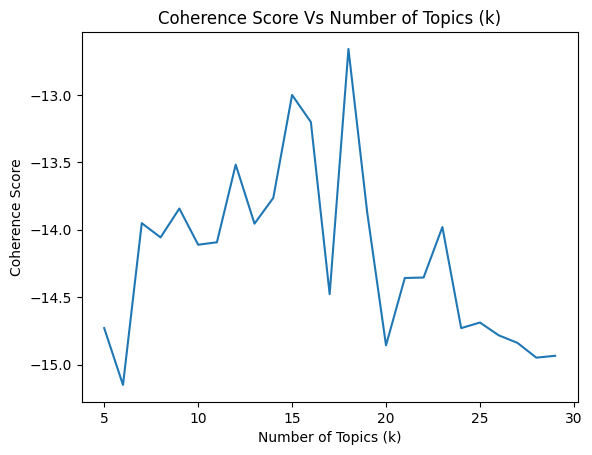

No of Topic Selected by Coherence Score: 18


<Figure size 640x480 with 0 Axes>

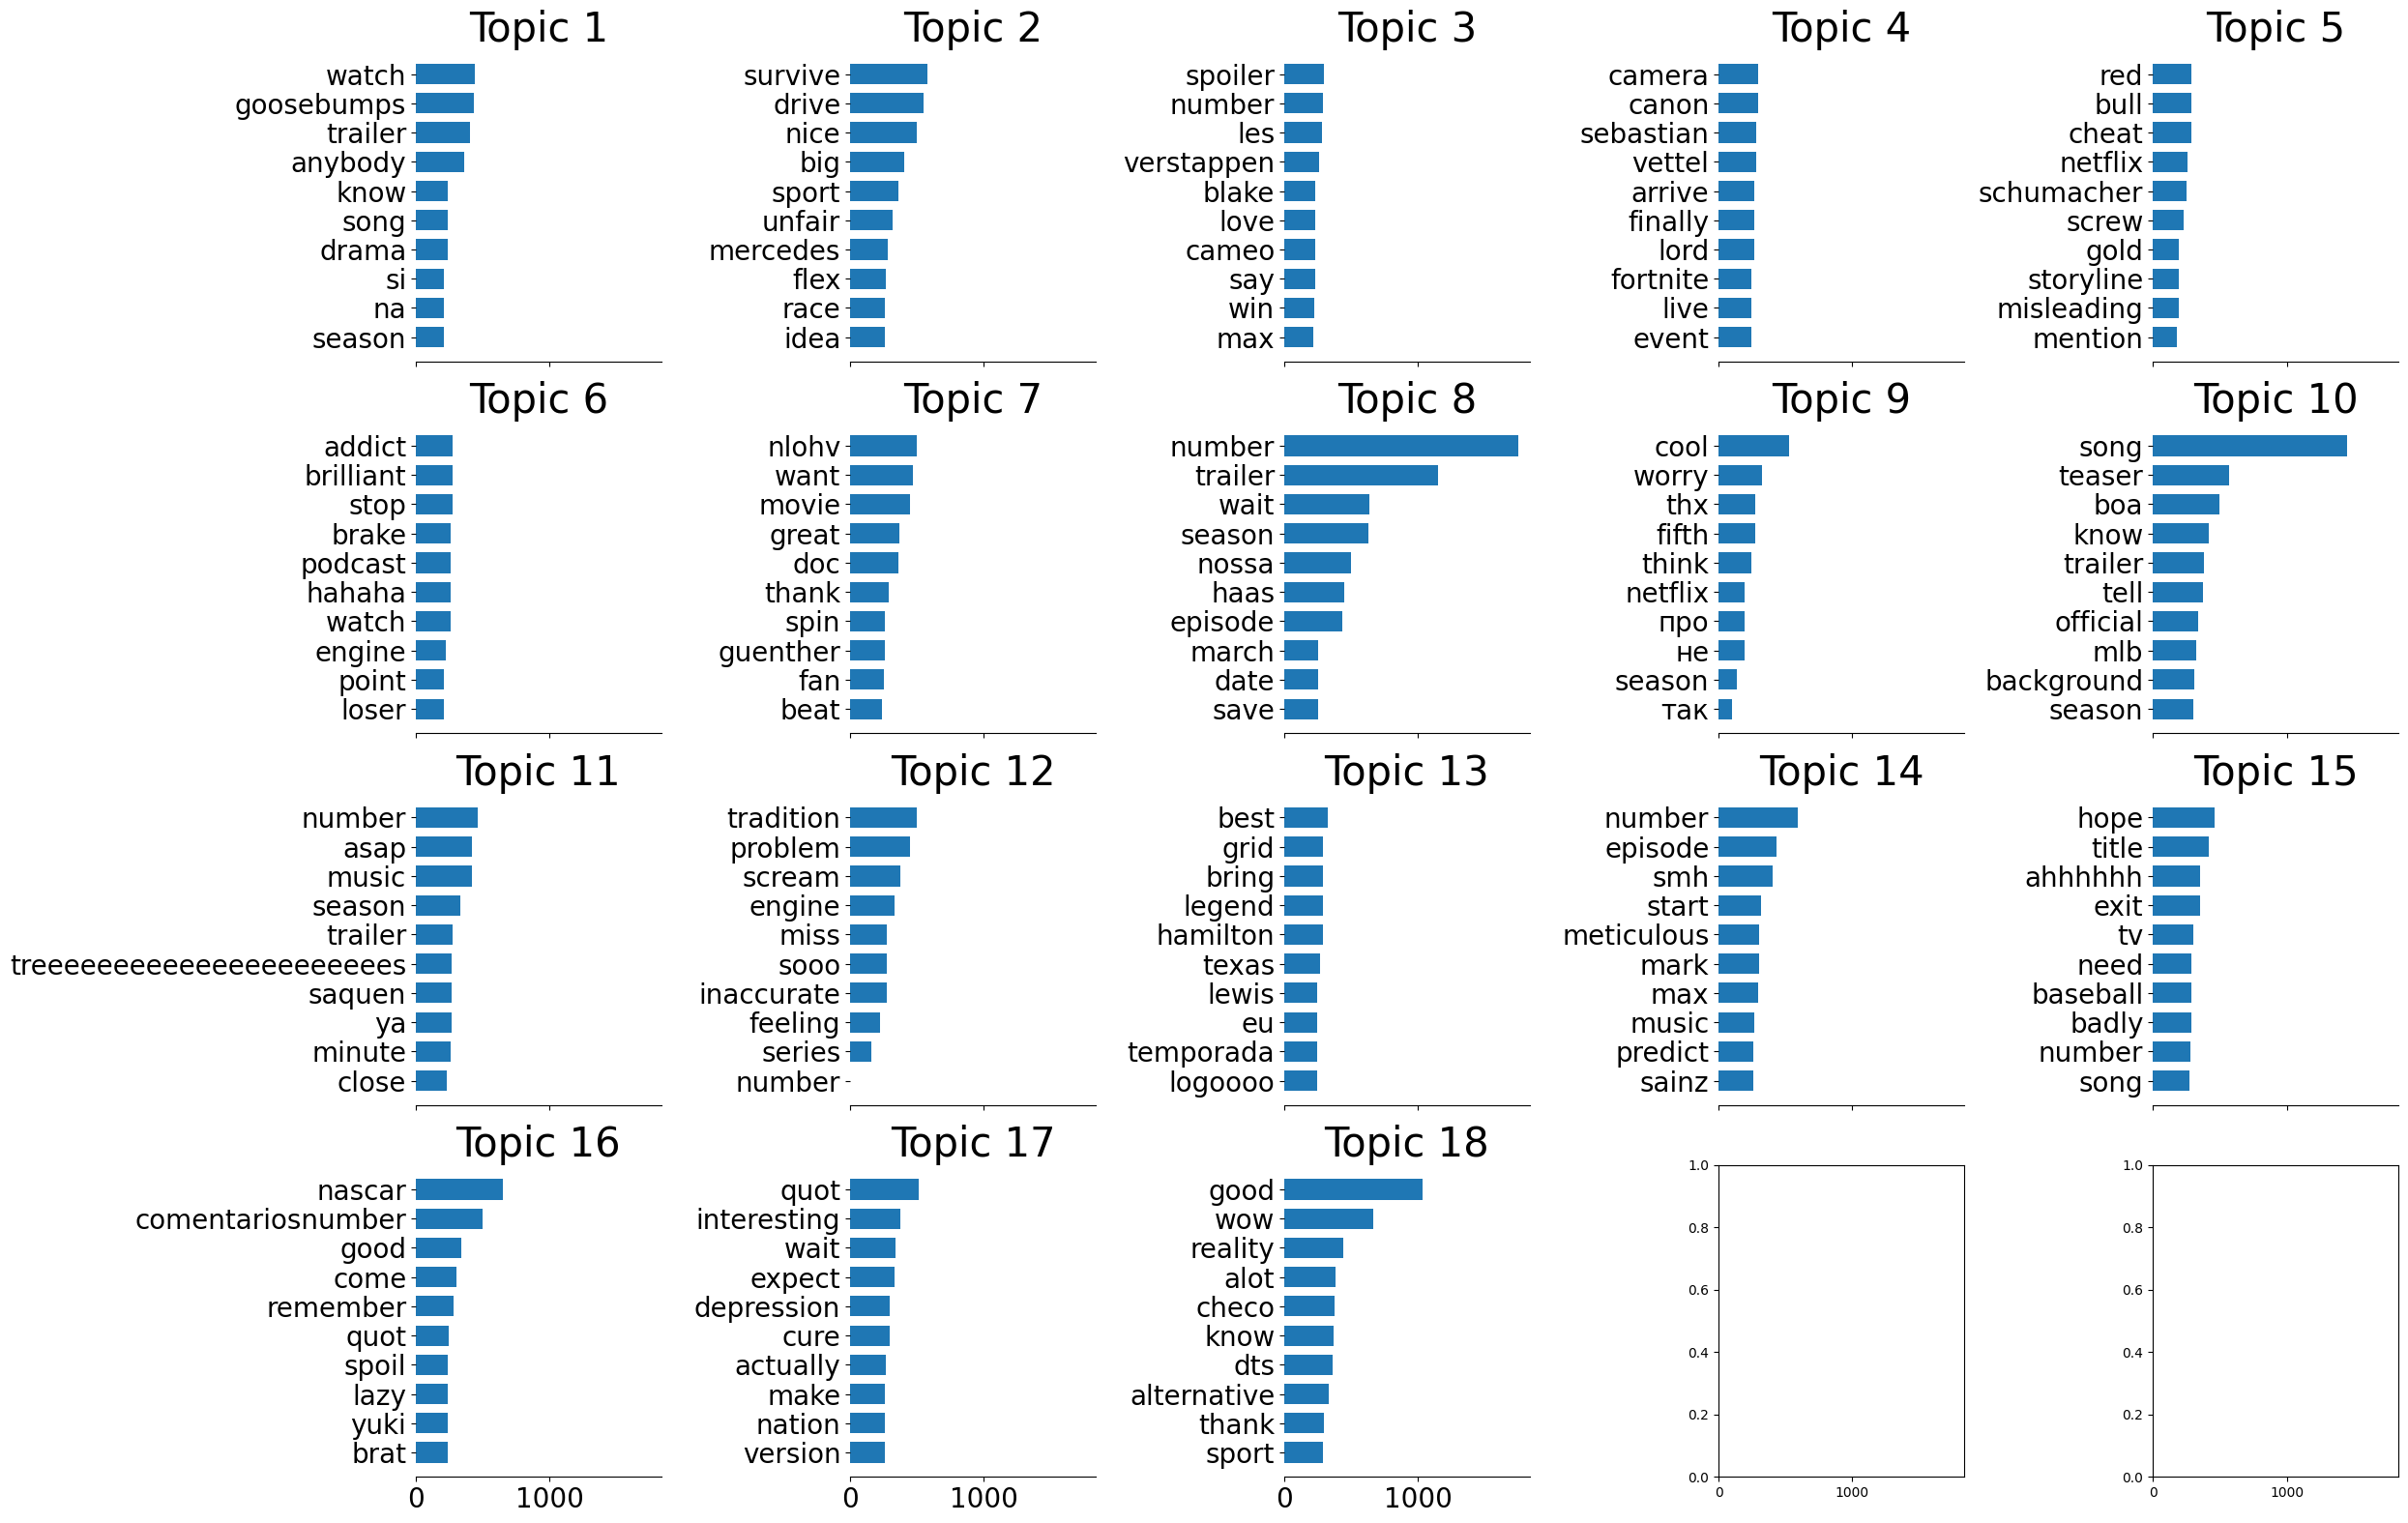

In [14]:
get_topic_plot(df_Netflix_trailers)
result
df_Netflix_trailers.to_csv('Clean_Data\df_Netflix_trailers_cleaned.csv',index=False)

# Netflix_highlights

File cleaning in progress...


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

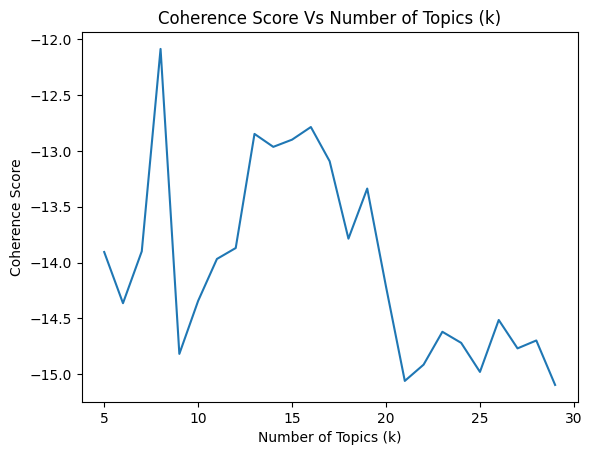

No of Topic Selected by Coherence Score: 8


<Figure size 640x480 with 0 Axes>

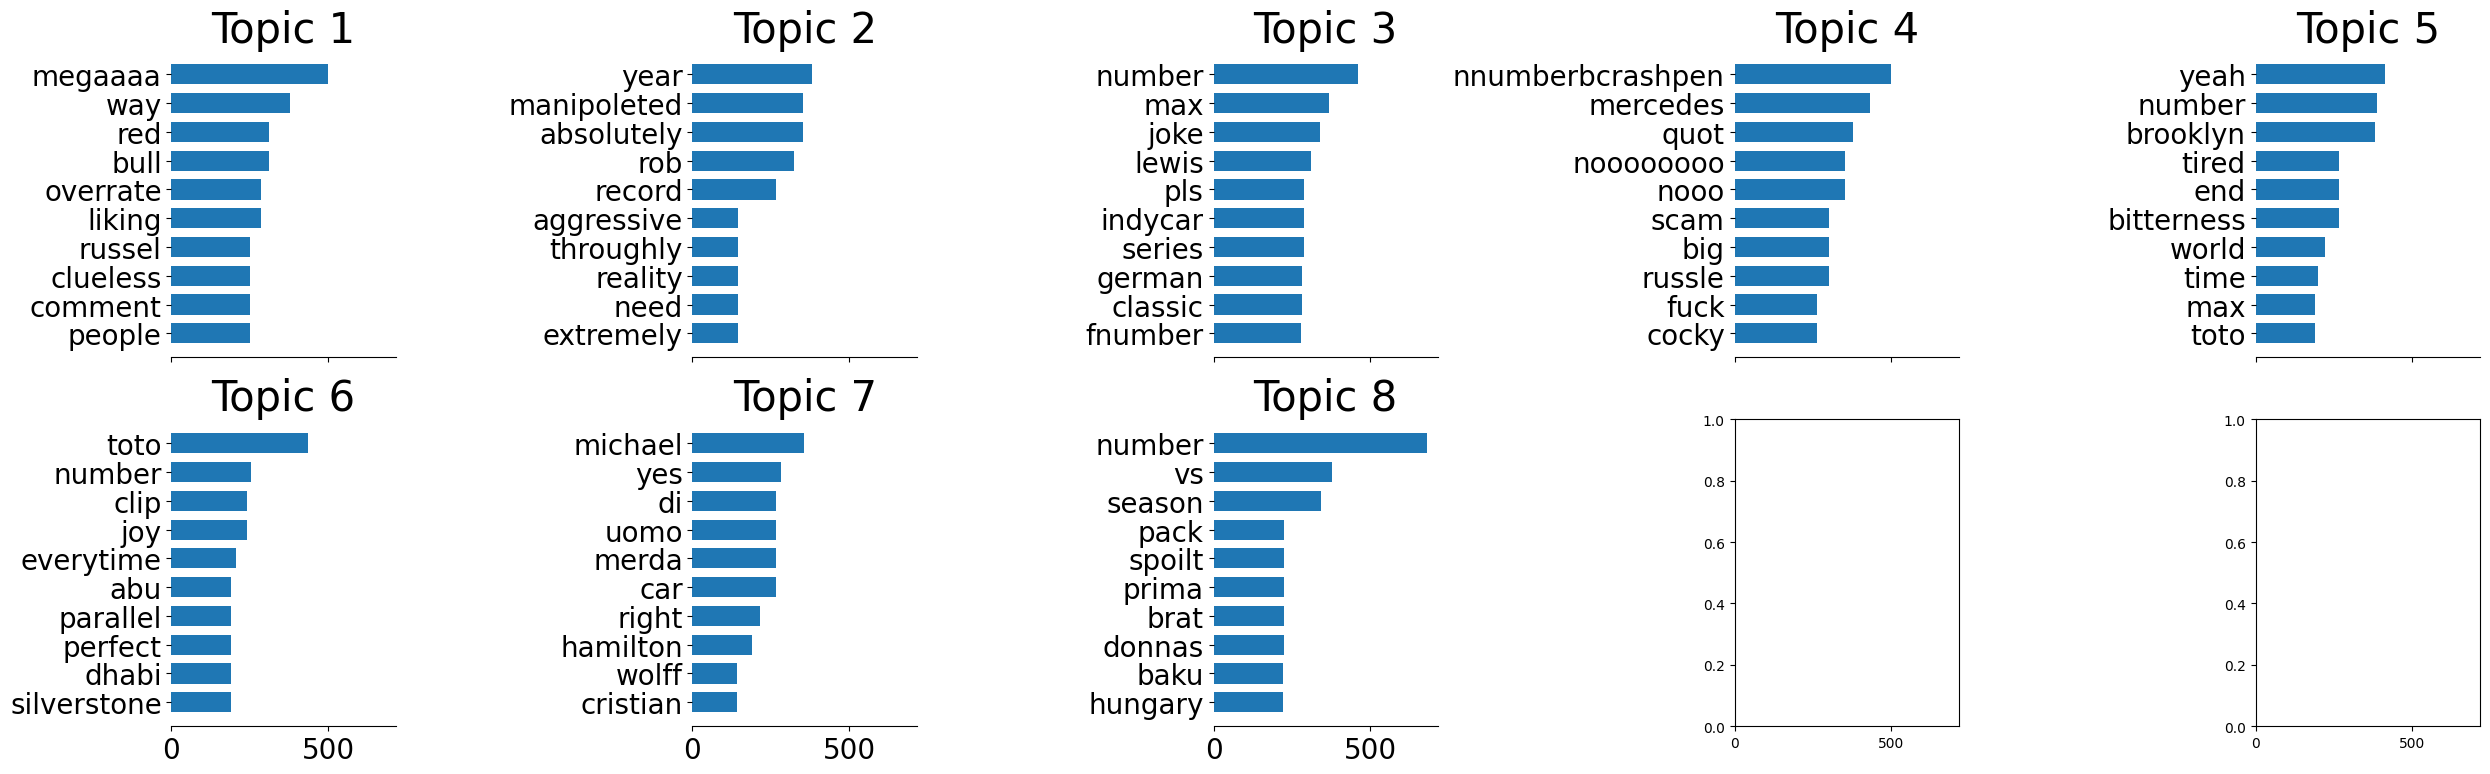

In [15]:
get_topic_plot(df_Netflix_highlights)
result
df_Netflix_highlights.to_csv('Clean_Data\df_Netflix_highlights_cleaned.csv',index=False)

# Formula1_trailers

File cleaning in progress...


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

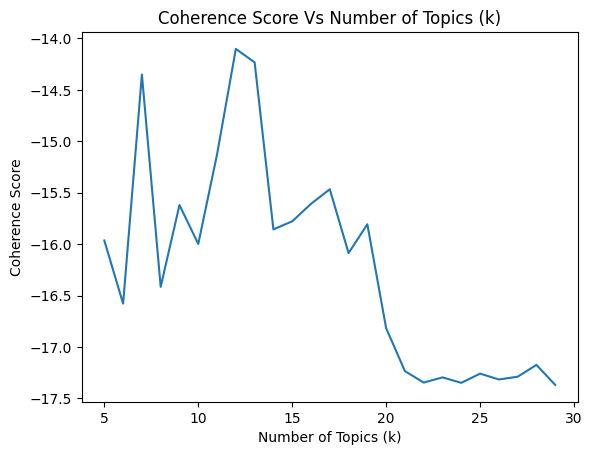

No of Topic Selected by Coherence Score: 12


<Figure size 640x480 with 0 Axes>

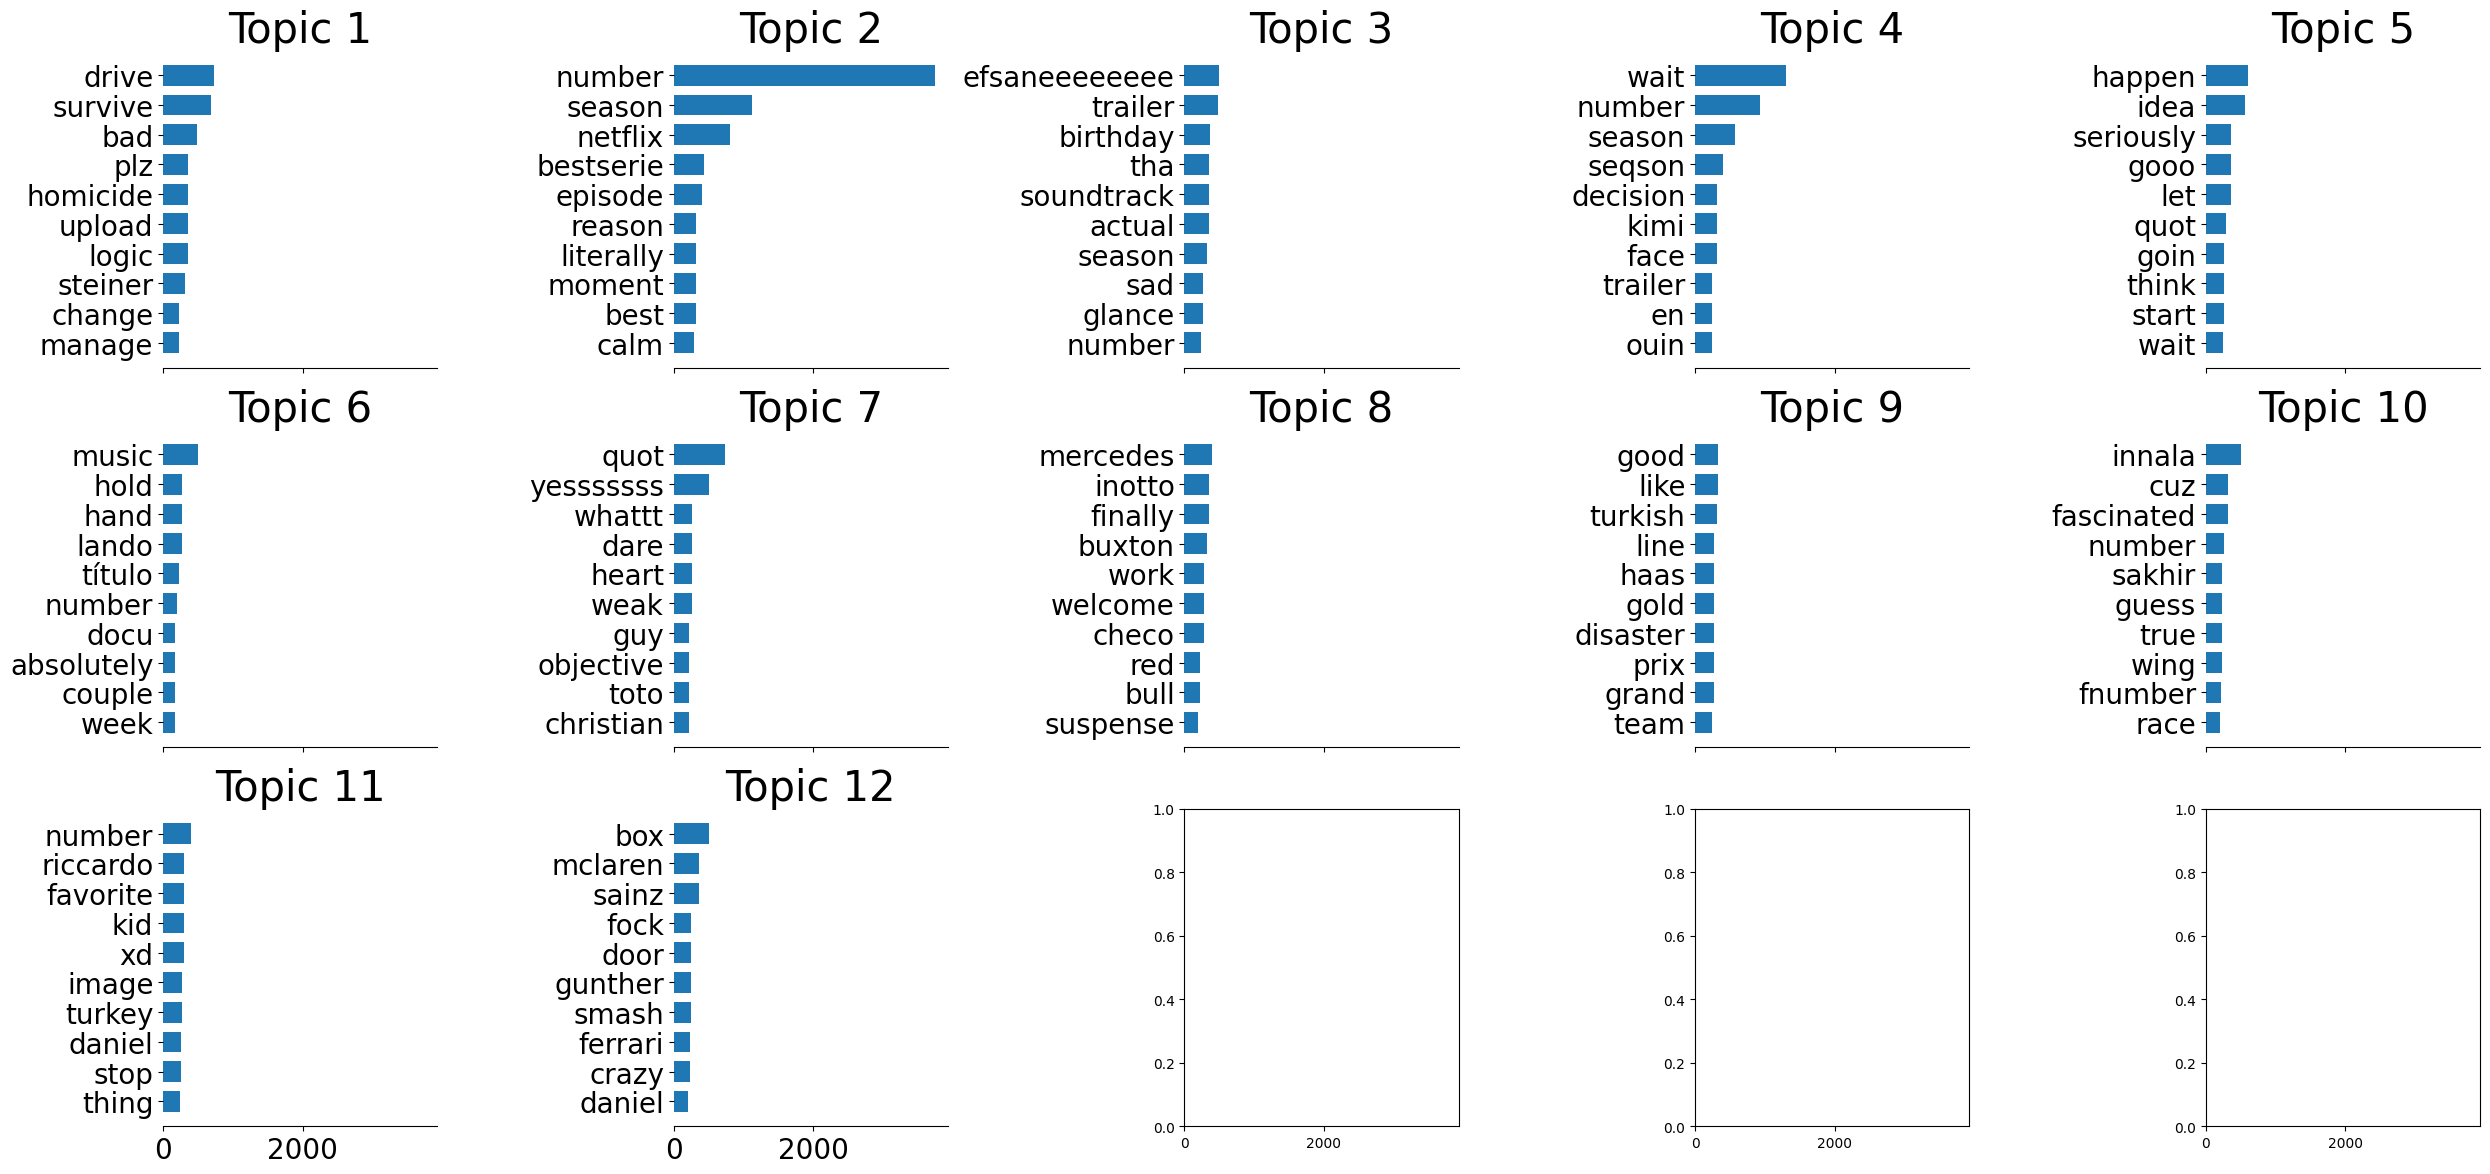

In [16]:
get_topic_plot(df_Formula1_trailers)
result
df_Formula1_trailers.to_csv('Clean_Data\df_Formula1_trailers_cleaned.csv',index=False)

# Formula1_highlights

File cleaning in progress...


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

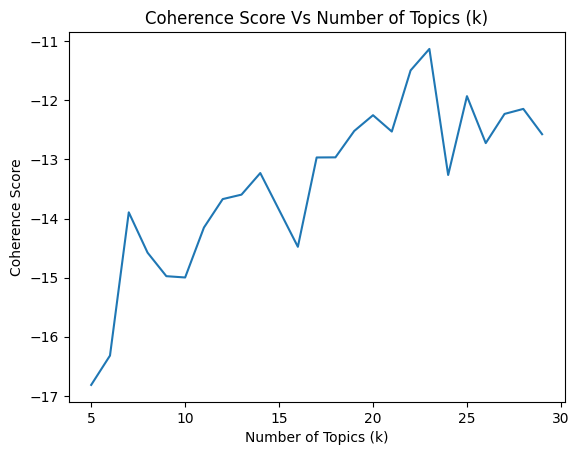

No of Topic Selected by Coherence Score: 23


<Figure size 640x480 with 0 Axes>

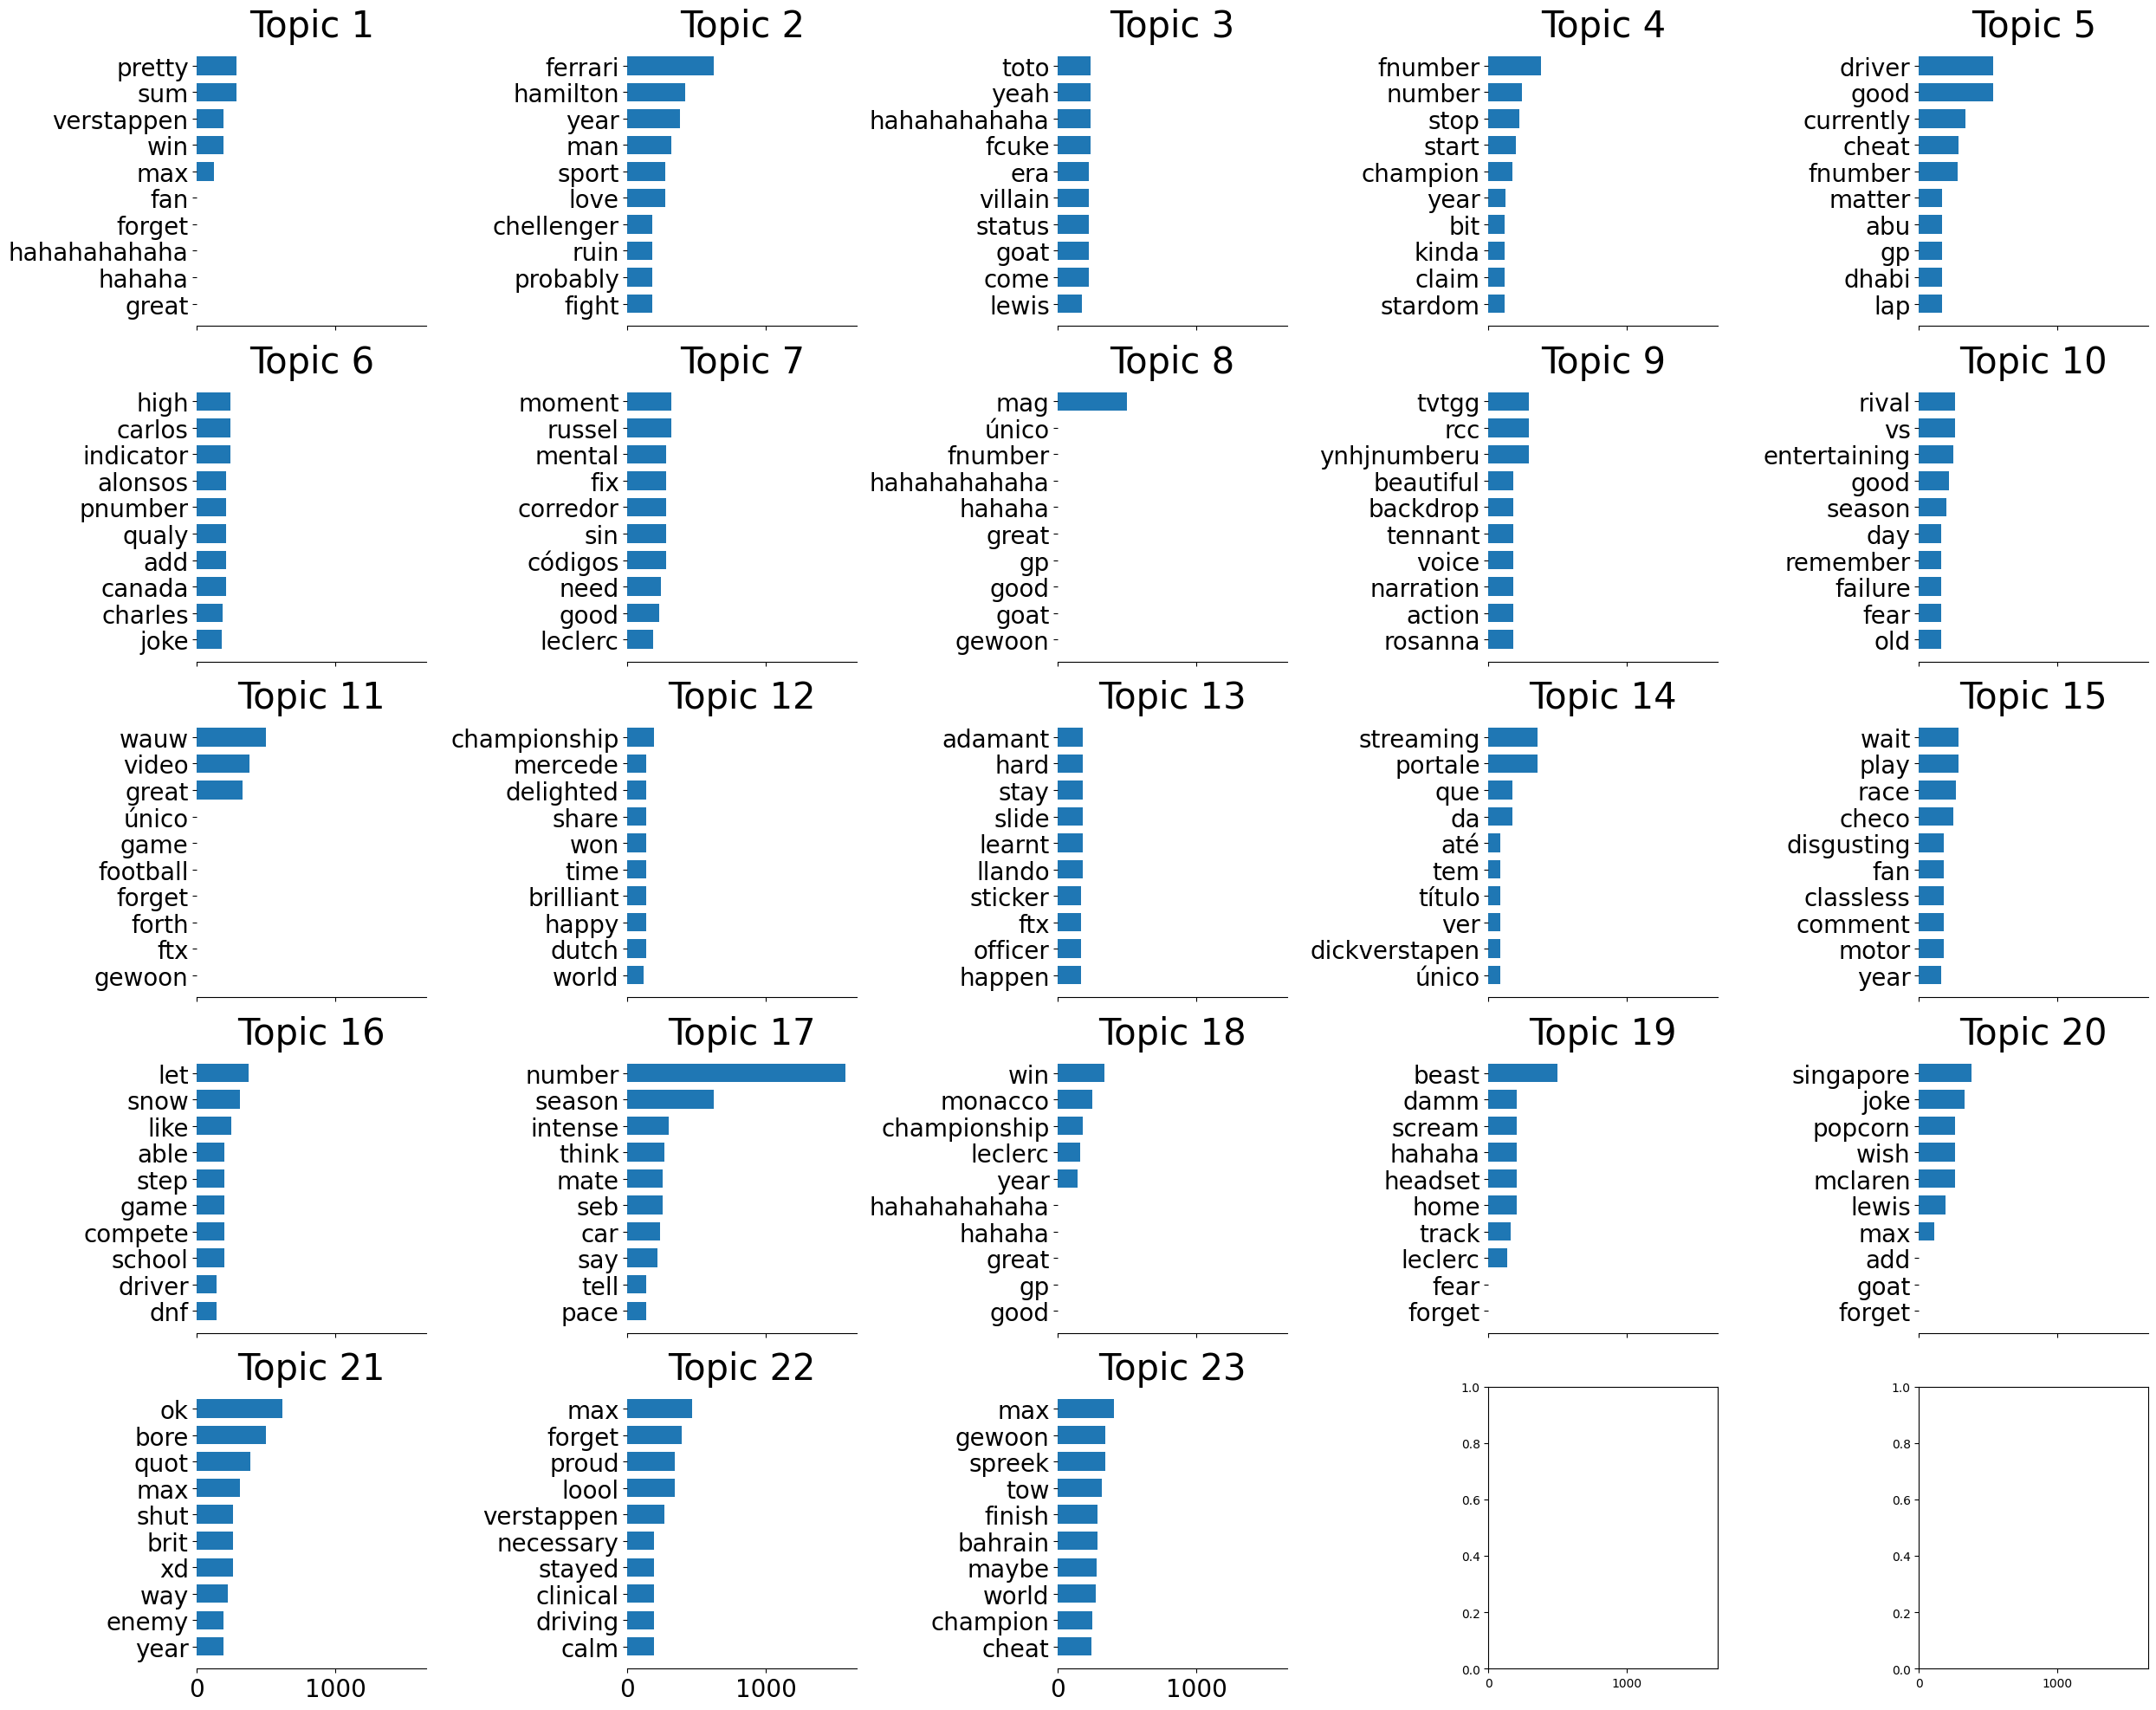

In [17]:
get_topic_plot(df_Formula1_highlights)
result
df_Formula1_highlights.to_csv('Clean_Data\df_Formula1_highlights_cleaned.csv',index=False)

# Miscellaneous

File cleaning in progress...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

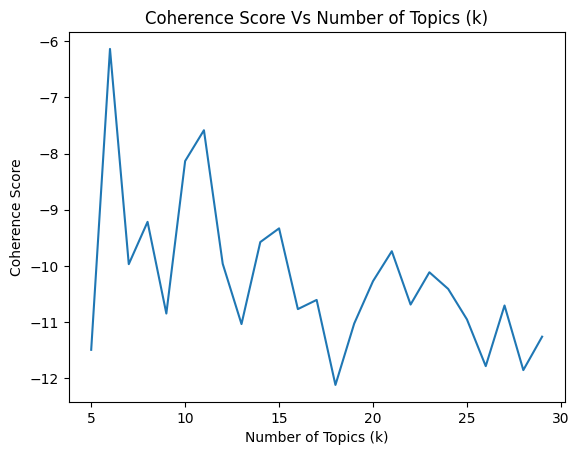

No of Topic Selected by Coherence Score: 6


<Figure size 640x480 with 0 Axes>

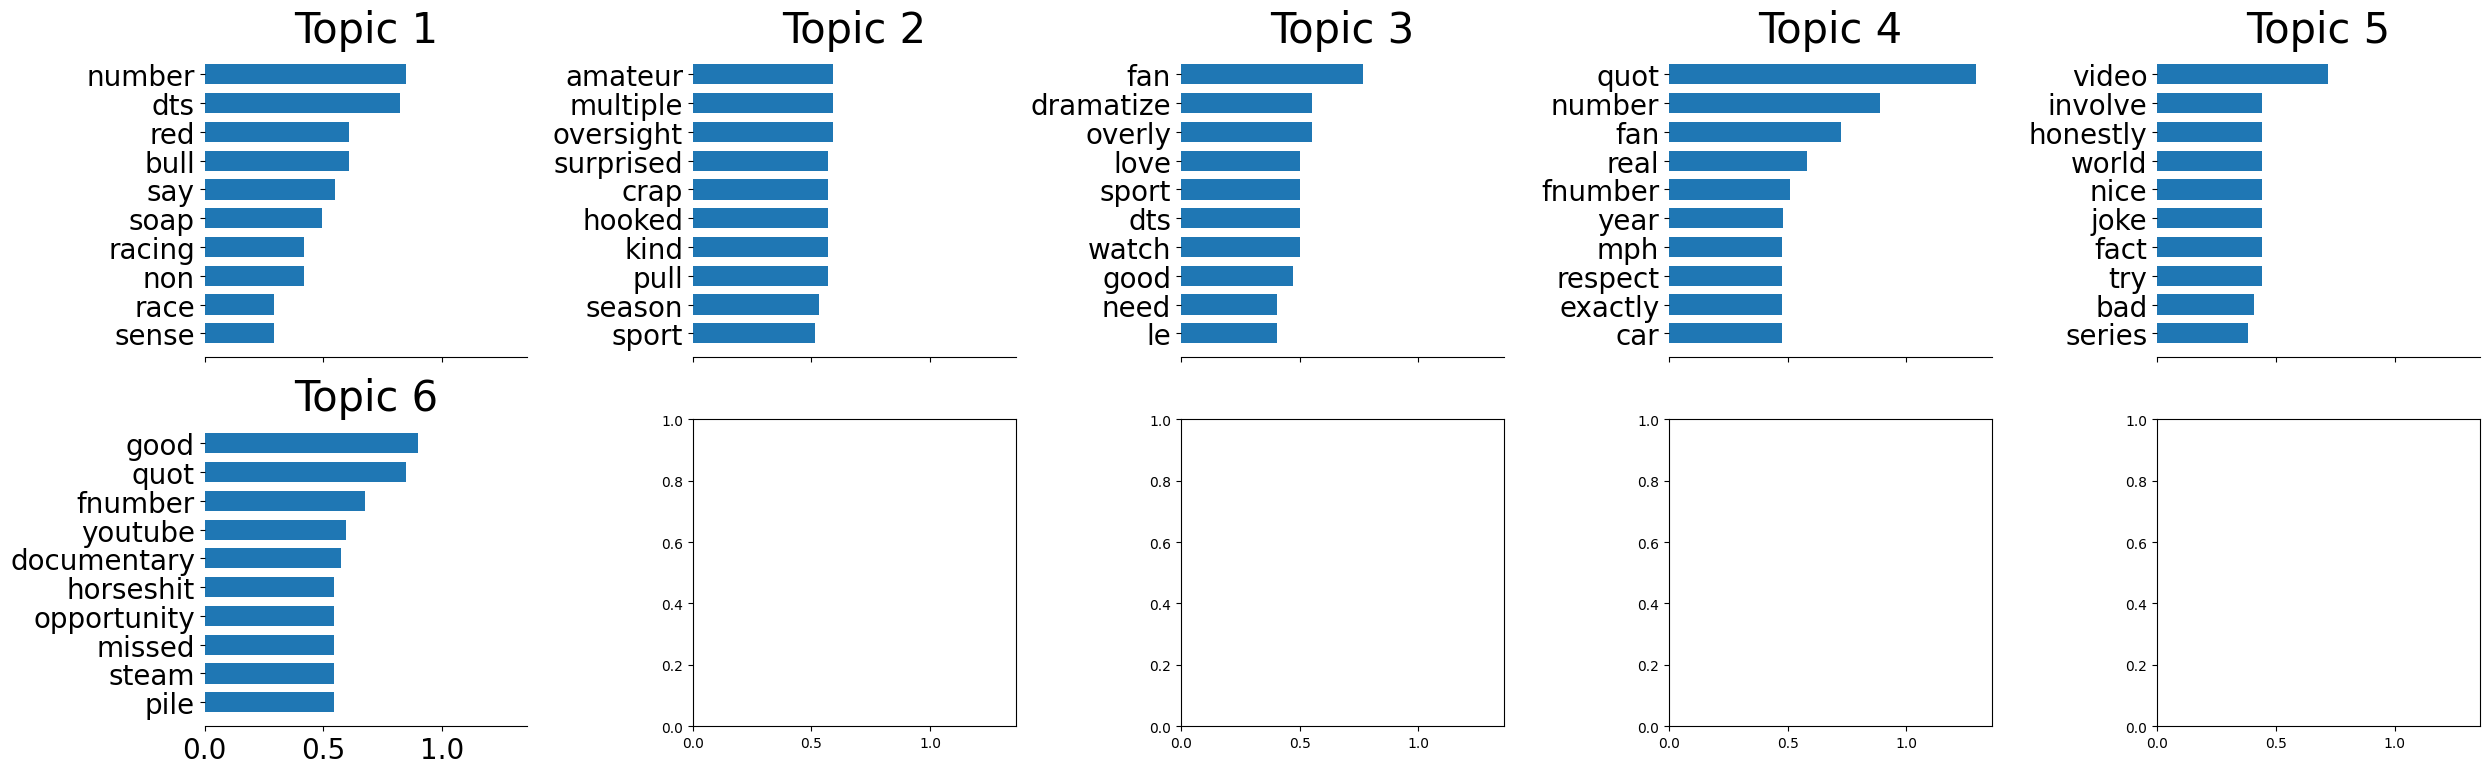

In [18]:
get_topic_plot(df_Miscellaneous)
result
df_Miscellaneous.to_csv('Clean_Data\df_Miscellaneous_cleaned.csv',index=False)

# Other Data

In [19]:
result

,Corpus,No_of_Comments,No_of_Tokens
0,df_Netflix_trailers,60000,660
1,df_Netflix_highlights,20000,251
2,df_Formula1_trailers,40000,350
3,df_Formula1_highlights,30000,299
4,df_Miscellaneous,15,189
